#  Fitting Spectrum

This notebook shows the aplication of fitting code to a 5-component spectrum 


In [1]:
import matplotlib.pylab as plt
import scipy.optimize as sop
import tables as tb
import pandas as pd
from Histogram import Histogram as hist
from PDF import PDF
import numpy as np
from Fits import Fit
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 32, 24
plt.rcParams["font.size"]               = 15
#plt.rcParams["figure.max_open_warning"] = 100

In [3]:
regions = ['Anode', 'Barrel', 'Cathode']
isotopes = ['K', 'Co', 'Bi', 'Tl']
nbinE = 150
minE, maxE = 700, 2700
nbinZ = 200
minZ, maxZ = 30, 500

In [4]:
def SigmaEstimator(E, rlim = 0.01):
    #res en Q_bb
    qbb = 2458     #MeV

    return rlim*(qbb*E)**0.5/2.35482

def Gaussianizator(E,sigma = -1, rlim = 0.01):
    if sigma<0:
        sigma = SigmaEstimator(E, rlim)
    return E #np.random.normal(E, sigma)


def h_Gauss(h,sigma = -1, rlim = 0.01):
    nbin = h.nbin
    minE = h.minlim
    maxE = h.maxlim
    hnew = hist([],nbin,minE,maxE)
    hnew.hist = np.zeros_like(h.hist)
    hnew.bins = h.bins[:]

    for i in range(nbin):
        Caux = h.bins[i]
        naux = h.hist[i]
        for j in range(int(naux)):
            hnew.Fill_hist(Gaussianizator(Caux, sigma, rlim))
    return hnew

# Reading and building MC PDFs

In [5]:
mc_pdfs = {}

In [6]:
with tb.open_file("../Data/pdf_bkg_fid.h5", "r") as f_pdfs:
    for region in regions:
        mc_pdfs[region] = {}
        for isotope in isotopes:
            group = getattr(f_pdfs.root, region)
            node  = getattr(group, isotope)
            mc_pdfs[region][isotope] = pd.DataFrame.from_records(node.read())

In [7]:
mc_pdfs[region][isotope].columns

Index(['index', 'evt_energy', 'numb_of_tracks', 'energy', 'length',
       'numb_of_voxels', 'eblob1', 'eblob2', 'eblob1_bary', 'eblob2_bary',
       'nS2', 'Xavg', 'Yavg', 'Zavg', 'minZ', 'maxZ', 'maxR', 'event',
       'x_blob_1', 'y_blob_1', 'z_blob_1', 'x_blob_2', 'y_blob_2', 'z_blob_2',
       'subindex', 'dist_blobs', 'region', 'isotope'],
      dtype='object')

In [8]:
histograms = {'E':[], 'z':[]}
name       = []
N_MC       = []

for region in regions:
        for isotope in isotopes:
            name.append(isotope+'_'+region) 
            df = mc_pdfs[region][isotope]
            
            histograms['E'].append(hist(Gaussianizator(df.energy*1.001, -1), nbinE, minE, maxE))
            histograms['z'].append(hist(df.Zavg                            , nbinZ, minZ, maxZ))                      
            N_MC           .append(len(df.evt_energy.unique()))




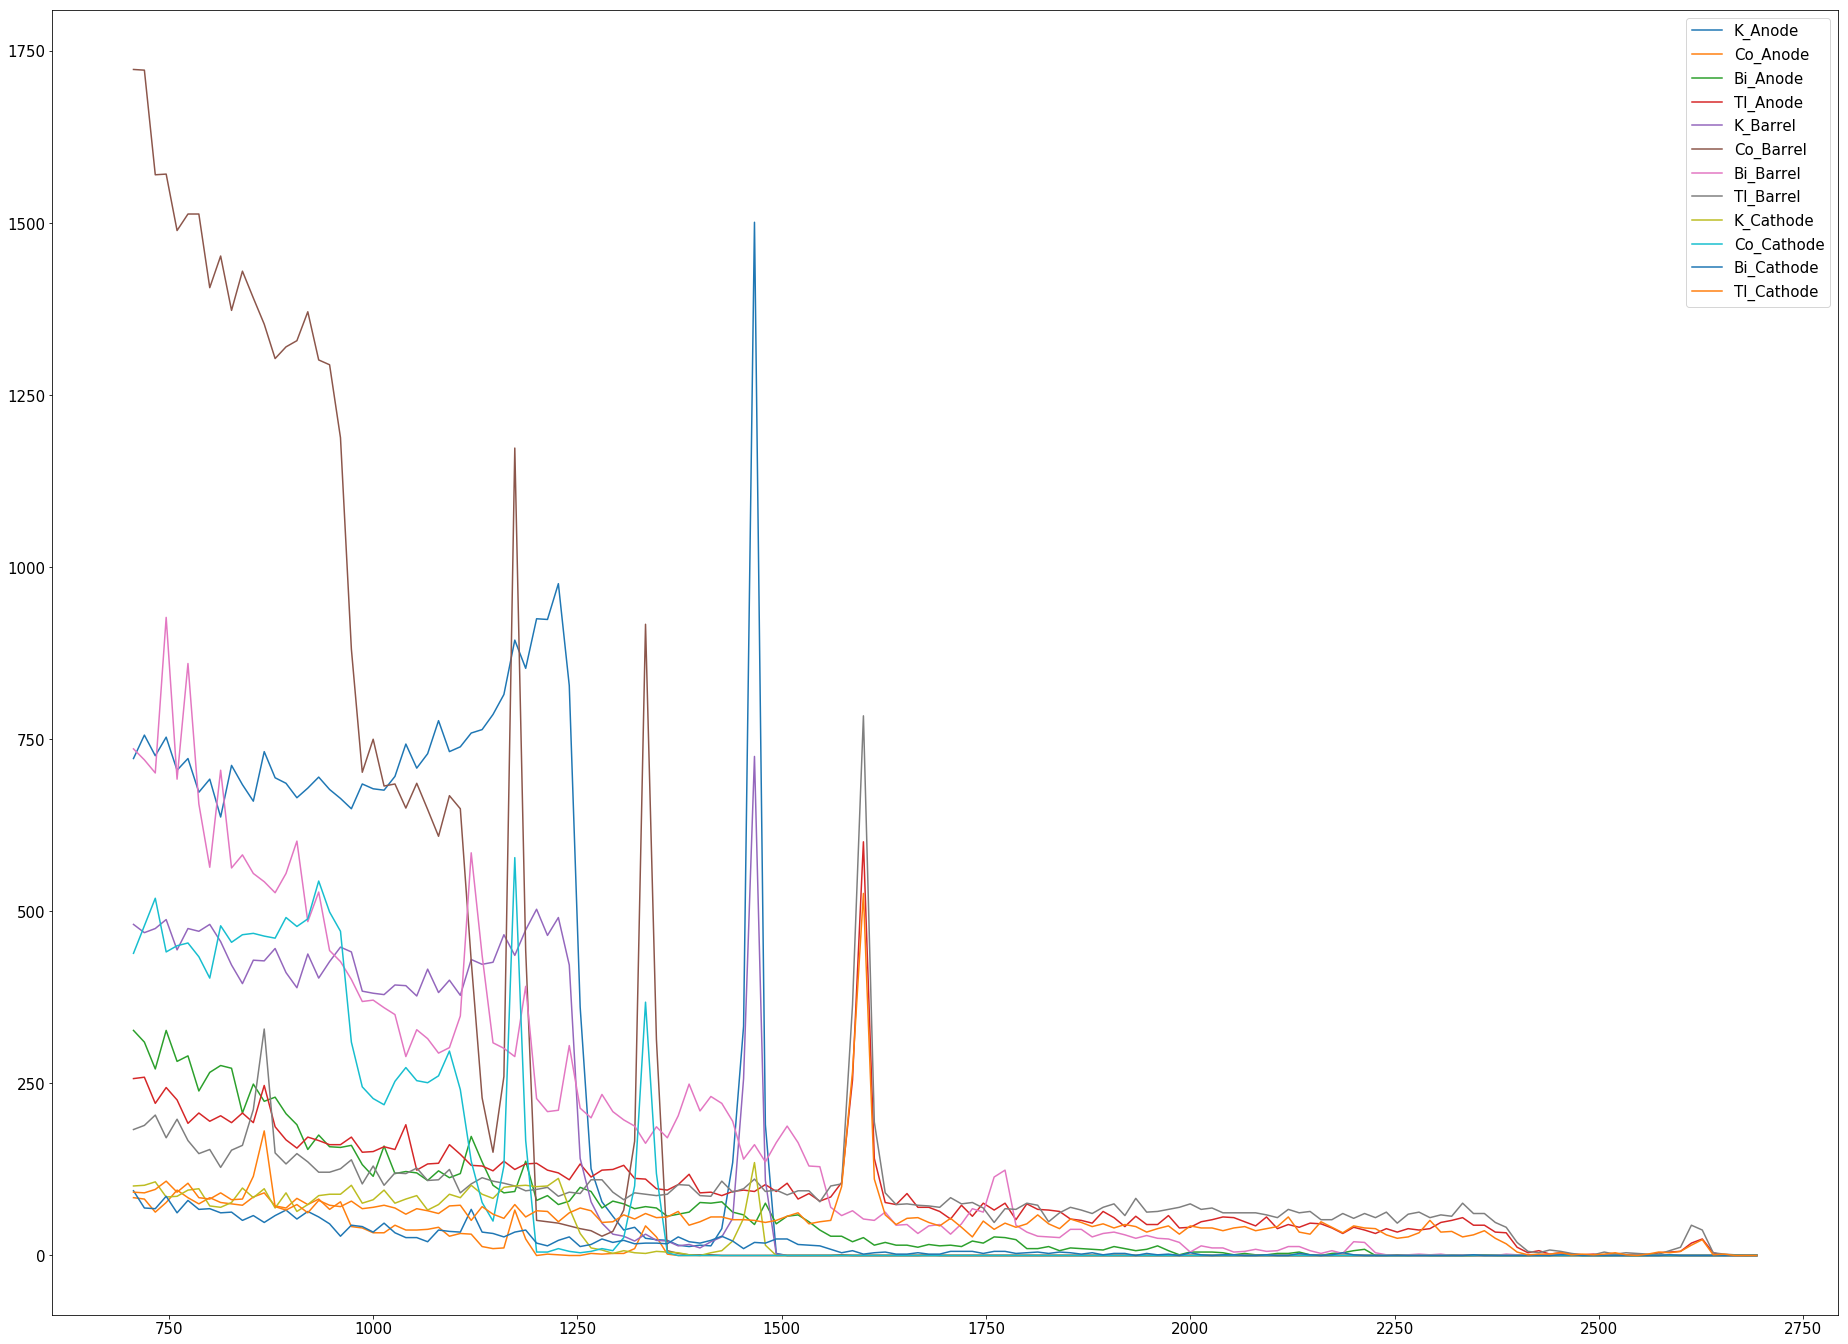

In [9]:
i = 0
for region in regions:
        for isotope in isotopes:
            h_ = histograms['E'][i]
            plt.plot(h_.bins, h_.hist, label=name[i])
            i += 1
plt.legend()

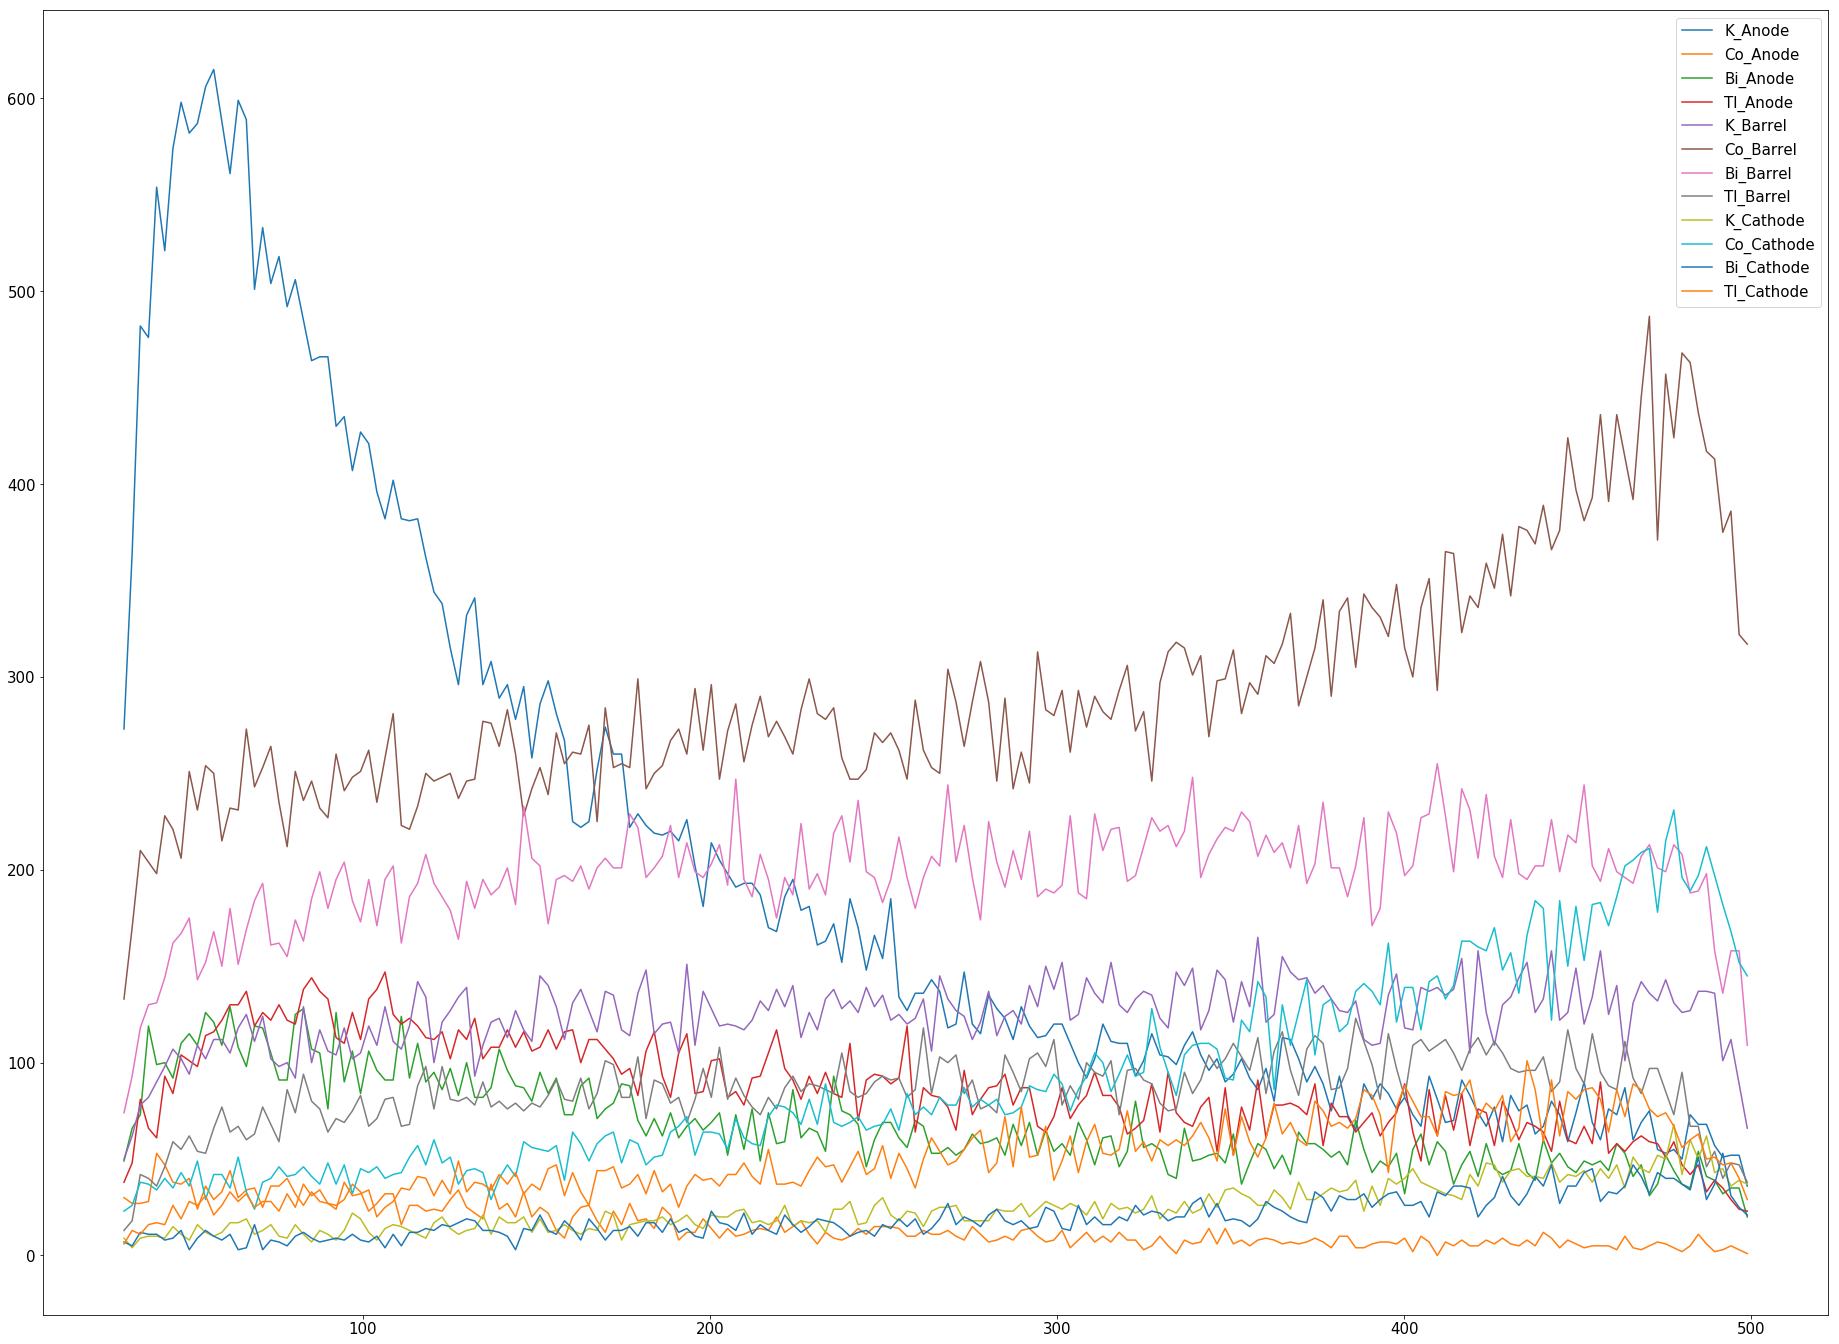

In [10]:
i = 0
for region in regions:
        for isotope in isotopes:
            h_ = histograms['z'][i]
            plt.plot(h_.bins, h_.hist, label=name[i])
            i += 1
plt.legend()

In [11]:
pdfs = {'E':[], 'z':[]}

interpol = 'cubic'

pdfs['E'] = [PDF(h_, interpolation=interpol) for h_ in histograms['E']]
pdfs['z'] = [PDF(h_, interpolation=interpol) for h_ in histograms['z']]

In [12]:
x_dict = {'E': [h_.bins for h_ in histograms['E']] , 'z': [h_.bins for h_ in histograms['z']]}


# Data reading

In [13]:
f_data     = tb.open_file("../Data/data_fid_run4b_vox-drop_1hitpersipm_calib.h5", "r")
table_data = pd.DataFrame.from_records(f_data.root.dataframe.table.read())
table_data.head()

h_total_e = hist(table_data.energy, nbinE, minE, maxE)
h_total_z = hist(table_data.Zavg  , nbinZ, minZ, maxZ)

totals = {'E': h_total_e    , 'z': h_total_z   }

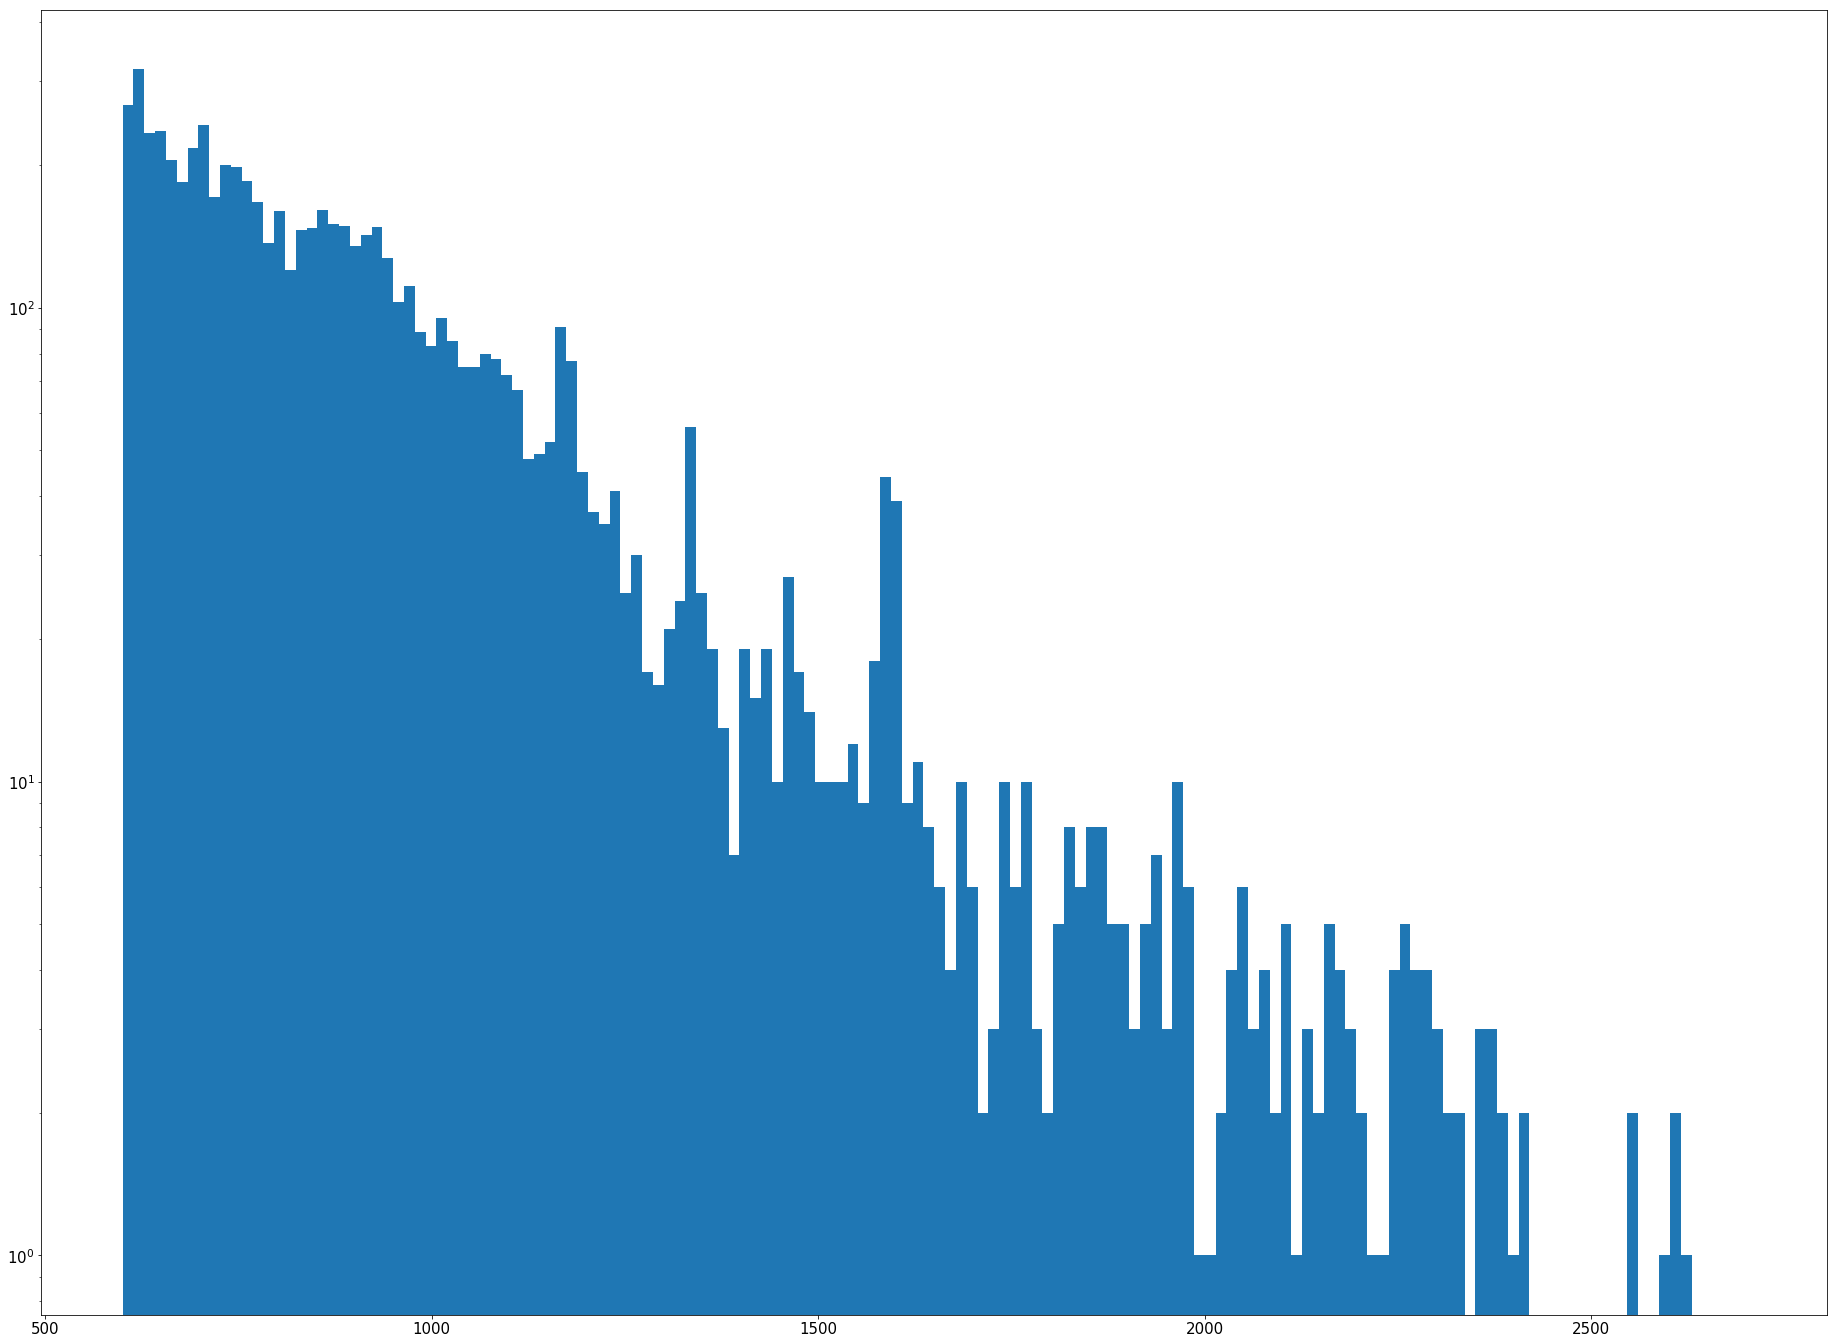

In [48]:
b = plt.hist(table_data.energy,150,[600,2700]);
plt.yscale('log')

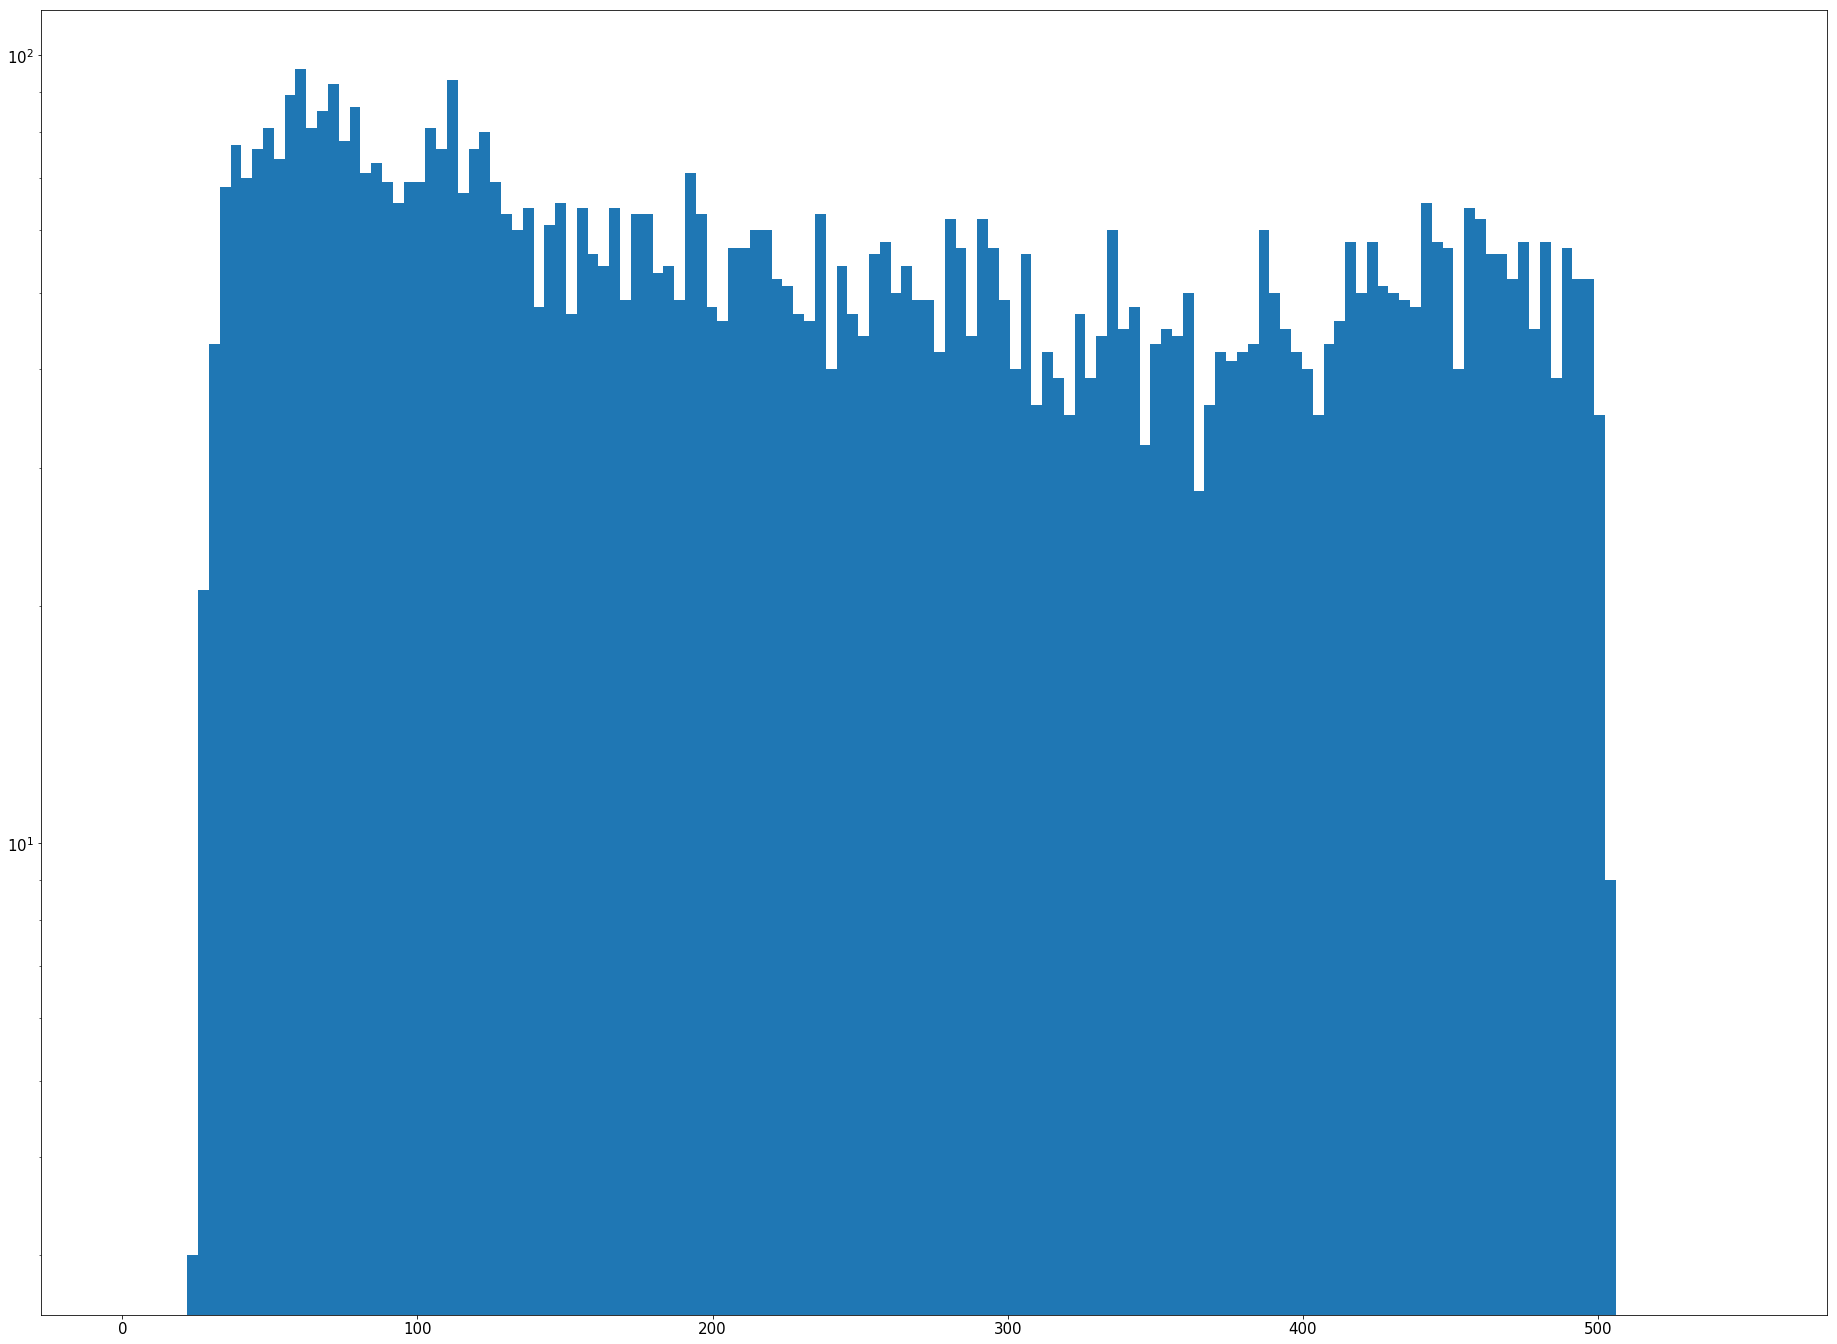

In [42]:
a = plt.hist(table_data.Zavg,150,[0,550]);
plt.yscale('log')

# Fitting

In [16]:
N_MC  = np.array(N_MC)
N_0MC = 27.167/(5.9*365.24) * N_MC

In [37]:
list( zip( N_MC,N_0MC))

[(39306, 495.5302675371105),
 (2877, 36.27030427172103),
 (12847, 161.96197392380955),
 (15750, 198.56005988168448),
 (23667, 298.36958331554456),
 (55960, 705.4870445066073),
 (37053, 467.1267237330829),
 (15060, 189.86123821067736),
 (4724, 59.55541097657635),
 (17800, 224.40438513612597),
 (3732, 47.049278951012475),
 (8793, 110.85324485966042)]

In [17]:
[[0.1,200]]*len(N_0MC)

[[0.1, 200],
 [0.1, 200],
 [0.1, 200],
 [0.1, 200],
 [0.1, 200],
 [0.1, 200],
 [0.1, 200],
 [0.1, 200],
 [0.1, 200],
 [0.1, 200],
 [0.1, 200],
 [0.1, 200]]

In [38]:
fit = Fit(x_dict, totals, pdfs, np.ones_like(N_0MC))

In [41]:
ratios = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
bounds = [[0  , 200000],
          [0.1, 200000],
          [0.1, 200000],
          [0.1, 200000],
          [0. , 200000],
          [0.1, 200000],
          [0.1, 200000],
          [0.1, 200000],
          [0. , 200000],
          [0.1, 200000],
          [0.1, 200000],
          [0.1, 200000]]

%time res_ll = fit.FitLLM(N_0MC,tol=1e-12,options={"maxiter":10000,'ftol':1e-20}, bounds=bounds)
print(res_ll)

CPU times: user 3.5 s, sys: 65.2 ms, total: 3.56 s
Wall time: 3.96 s
    chi2: array([1975.76728647,    0.        ])
     err: array([4.68485139, 4.69088509, 4.84938923, 4.72431165, 4.71112094,
       4.63176422, 4.69046551, 4.8410877 , 4.63546593, 4.68490842,
       4.65762405, 5.44943771])
     fun: 36628.01044372924
     jac: array([-0.0007276 ,  0.0007276 ,  0.01527951,  0.00363798,  0.00218279,
       -0.00509317,  0.0007276 ,  0.01455192, -0.00509317, -0.0007276 ,
       -0.00291038,  0.07057679])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 177
     nit: 32
  status: 1
 success: True
       x: array([514.04339292, 514.04942589, 514.20793558, 514.0828568 ,
       514.06966578, 513.99030824, 514.04900768, 514.19962787,
       513.99401304, 514.0434497 , 514.01616801, 514.80798482])


array([495.53026754,  36.27030427, 161.96197392, 198.56005988,
       298.36958332, 705.48704451, 467.12672373, 189.86123821,
        59.55541098, 224.40438514,  47.04927895, 110.85324486])

In [29]:
result    = res_ll.x
factors   = res_ll.x * N_0MC
factors   = np.array([514.04165853, 514.04179216, 514.04164491, 514.04166726,
                      514.04167153, 514.0416711 , 514.04166152, 514.04166413,
                      514.04163411, 514.04167932, 514.04171903, 514.04167595])

pdfs_plot = {'E':[], 'z':[]}

interpol = 'nearest'

pdfs_plot['E'] = [PDF(h_, factor=factors[i], interpolation=interpol) for h_, i in zip(histograms['E'], range(len(N_0MC)))]
pdfs_plot['z'] = [PDF(h_, factor=factors[i], interpolation=interpol) for h_, i in zip(histograms['z'], range(len(N_0MC)))]


In [30]:
Ep = np.linspace(totals['E'].bins[0],totals['E'].bins[-1],1000)
Zp = np.linspace(totals['z'].bins[0],totals['z'].bins[-1],1000)

y_e = [pdf.pdf(Ep) for pdf in pdfs_plot['E']] 
y_z = [pdf.pdf(Zp) for pdf in pdfs_plot['z']] 


fittotal_e = np.sum(y_e, axis=0)
fittotal_z = np.sum(y_z, axis=0)

anode_e   = y_e[0] + y_e[1] + y_e[2]  + y_e[3]
barrel_e  = y_e[4] + y_e[5] + y_e[6]  + y_e[7]
cathode_e = y_e[8] + y_e[9] + y_e[10] + y_e[11]

anode_z   = y_z[0] + y_z[1] + y_z[2]  + y_z[3]
barrel_z  = y_z[4] + y_z[5] + y_z[6]  + y_z[7]
cathode_z = y_z[8] + y_z[9] + y_z[10] + y_z[11]

K_e  = y_e[0] + y_e[4] + y_e[8] 
Co_e = y_e[1] + y_e[5] + y_e[9]
Bi_e = y_e[2] + y_e[6] + y_e[10]
Tl_e = y_e[3] + y_e[7] + y_e[11] 

In [52]:
q,w,e = b

In [53]:
w = w[:-1]+np.diff(w)

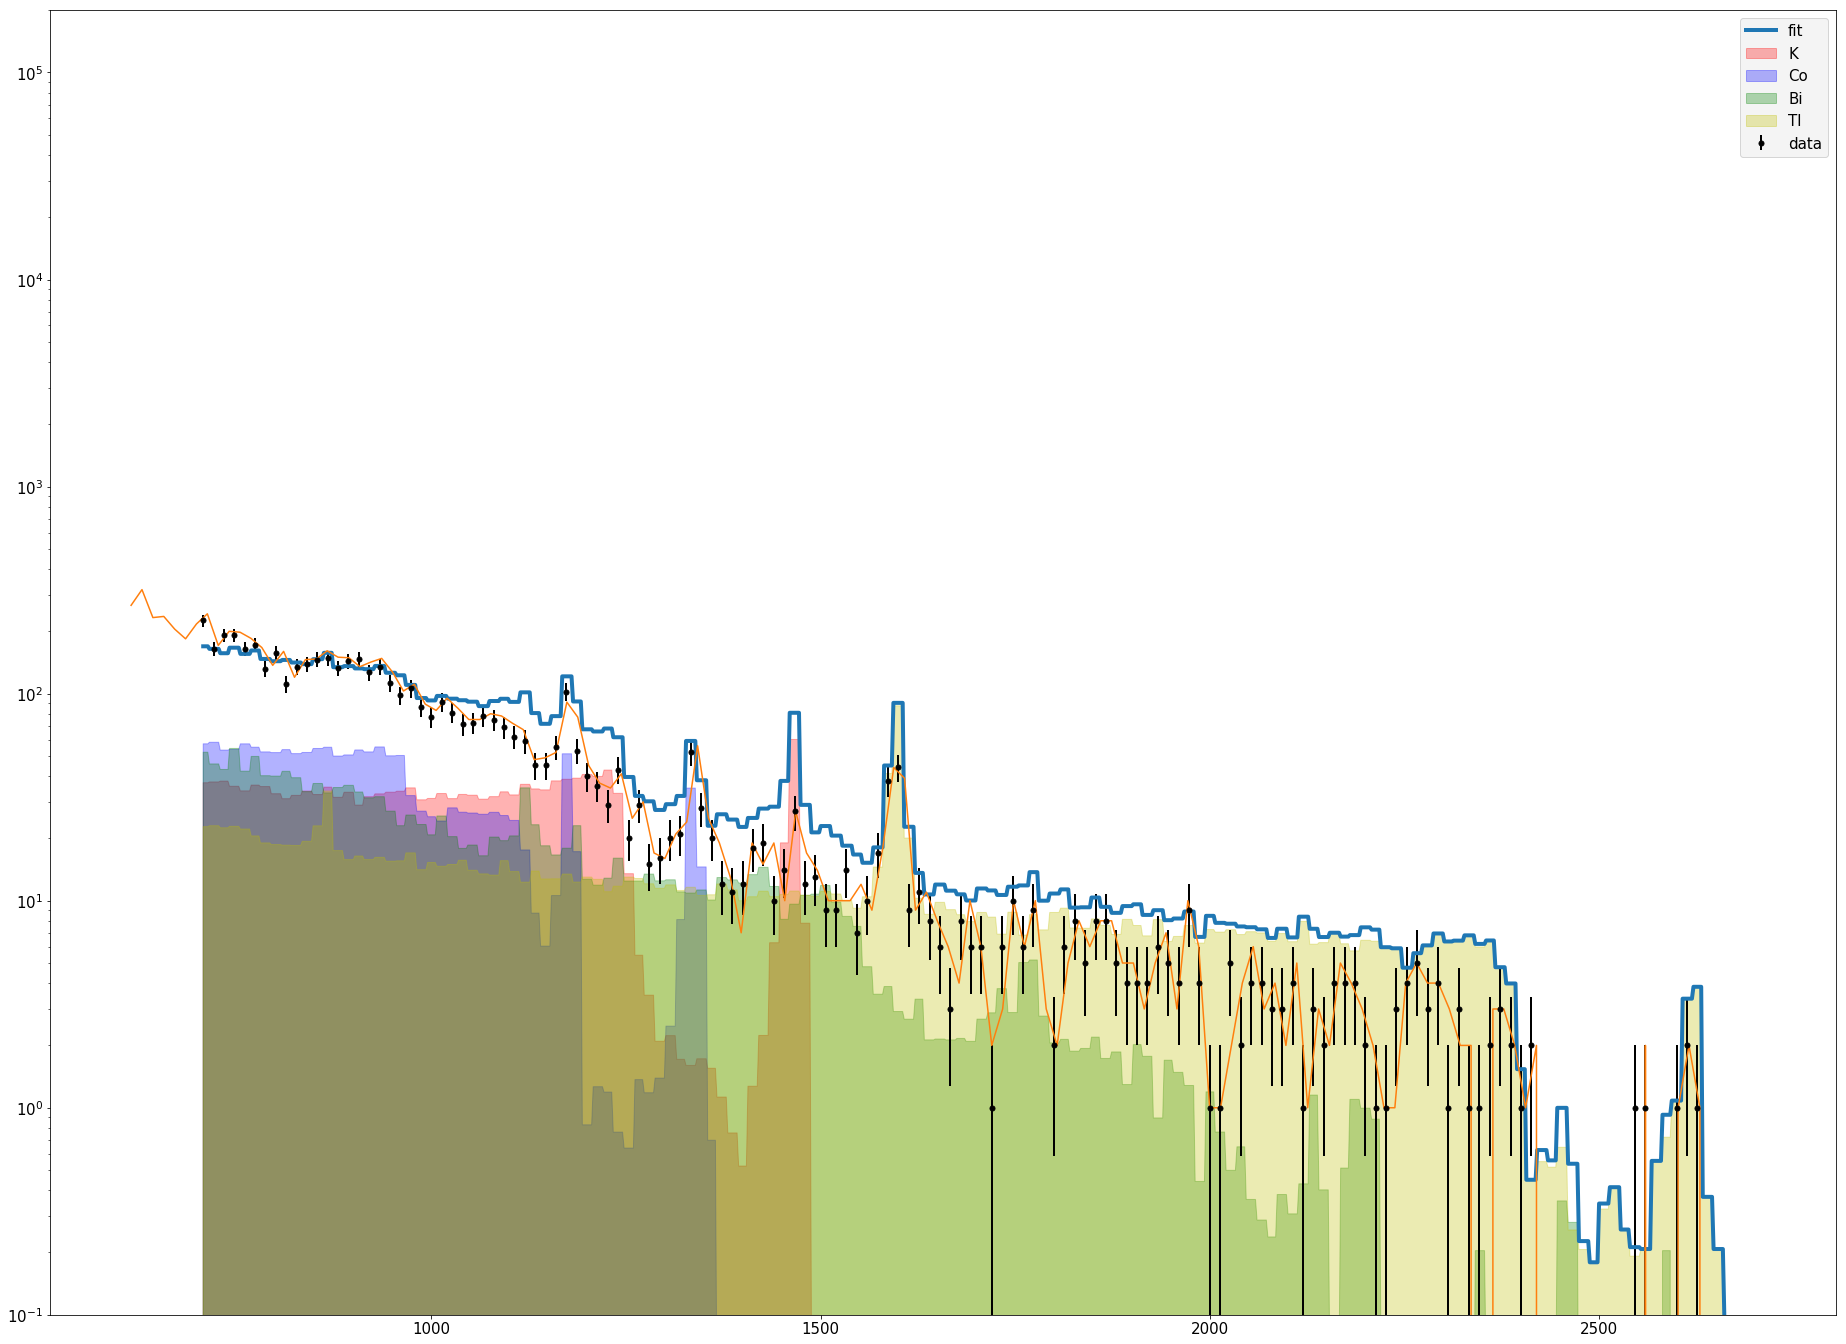

In [54]:
alfa= 0.3
plt.semilogy()
plt.ylim(1e-1,2e5)

plt.errorbar(totals['E'].bins, totals['E'].hist, yerr=np.sqrt(totals['E'].hist),
             marker='.', markersize=10, elinewidth=2, linewidth=0,label='data',color='black')

plt.plot(Ep, fittotal_e, label='fit', linewidth=4,)


plt.fill_between(Ep, 0 , K_e  , label='K'  ,alpha=alfa,color='r')
plt.fill_between(Ep, 0 , Co_e , label='Co' ,alpha=alfa,color='b')
plt.fill_between(Ep, 0 , Bi_e , label='Bi' ,alpha=alfa,color='g')
plt.fill_between(Ep, 0 , Tl_e , label='Tl' ,alpha=alfa,color='y')

plt.plot(w,q)

'''
plt.fill_between(Ep, 0 , fit_0_a_e, label='fit_e_0',alpha=alfa,color='r')
plt.fill_between(Ep, 0 , fit_1_a_e, label='fit_e_1',alpha=alfa,color='b')
plt.fill_between(Ep, 0 , fit_2_a_e, label='fit_e_2',alpha=alfa,color='g')

plt.legend().get_frame().set_facecolor('0.95')


plt.figure()
plt.errorbar(h_total_z.bins, h_total_z.hist, yerr=np.sqrt(h_total_e.hist),
             marker='.', elinewidth=1, linewidth=0,label='data',color='black')

plt.plot(Zp, fittotal_z,label='fit')

plt.fill_between(Zp, 0 , fit_a_0_z, label='fit_z_0',alpha=alfa,color='r')
plt.fill_between(Zp, 0 , fit_a_1_z, label='fit_z_1',alpha=alfa,color='b')
'''
plt.legend().get_frame().set_facecolor('0.95')


In [44]:
q,w,e = a

In [46]:
w = w[:-1]+np.diff(w)

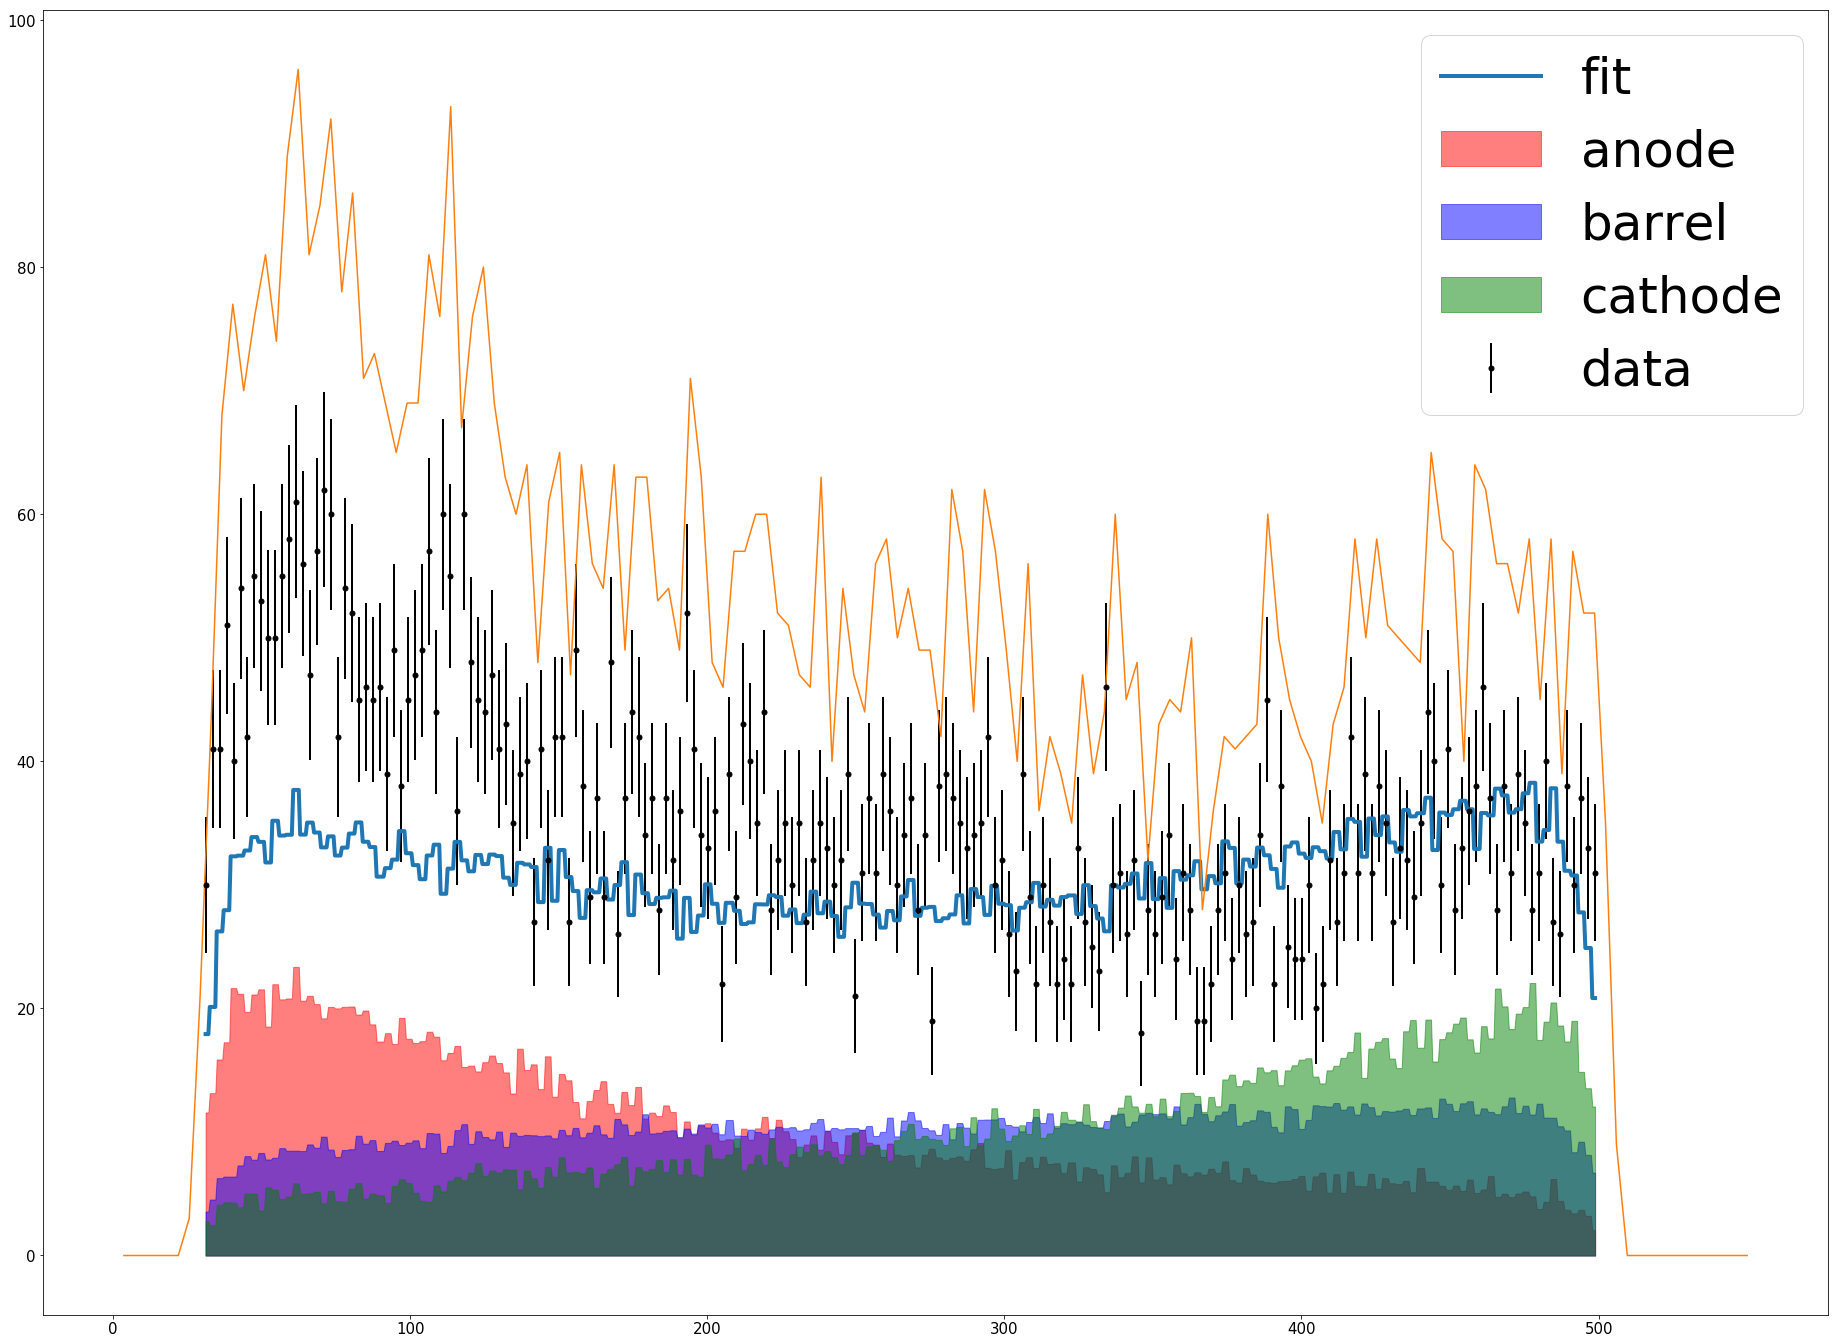

In [47]:
alfa= 0.5


plt.errorbar(totals['z'].bins, totals['z'].hist, yerr=np.sqrt(totals['z'].hist),
             marker='.', markersize=10, elinewidth=2, linewidth=0,label='data',color='black')

plt.plot(Zp, fittotal_z, label='fit', linewidth=4,)

plt.fill_between(Zp, 0 , anode_z  , label='anode'  ,alpha=alfa,color='r')
plt.fill_between(Zp, 0 , barrel_z , label='barrel' ,alpha=alfa,color='b')
plt.fill_between(Zp, 0 , cathode_z, label='cathode',alpha=alfa,color='g')

plt.plot(w,q)

'''

plt.legend().get_frame().set_facecolor('0.95')


plt.figure()
plt.errorbar(h_total_z.bins, h_total_z.hist, yerr=np.sqrt(h_total_e.hist),
             marker='.', elinewidth=1, linewidth=0,label='data',color='black')

plt.plot(Zp, fittotal_z,label='fit')

plt.fill_between(Zp, 0 , fit_a_0_z, label='fit_z_0',alpha=alfa,color='r')
plt.fill_between(Zp, 0 , fit_a_1_z, label='fit_z_1',alpha=alfa,color='b')
'''
plt.legend(fontsize=50)

In [24]:
from scipy.special import gammaln

In [25]:
def generalLogPoisson(x, mu):
    '''
    Returns the natural logarithm of the probability value of "x"
    for a Poisson distribution with mean "mu"
    '''
    return (-mu+x*np.log(mu)-gammaln(x+1))

In [26]:
generalLogPoisson(1,0)

-inf